The workbook below lists all the dependencies, primarily sci kit learn. There is be a section that also uses TF-learn (tensorflow learn) which has not been thoroughly worked out (it is not currently in the execution flow). The aim is to model the ccs code 48 which is Thyroid conditions.. To determine which subgroups might have a higher propensity to have the condtion,, so for instance the dataset currently has an overall negative instance of

    Test - RF Mean Accuracy:  0.935107915594  What is in the population
    Test - RF (1- TestMean):  0.9391578168    What our model says Which at one level is currently dissapointing,
    
However what we really want and will be adding to the notebook:

Is a selected sub-set of the prospects that have a higher than .0649 probability of having ccs48 (1-.93510 from above)

Model evaluation: score the model on test data with whatever probability threshold is appropriate. This may be low as  a few %. You need to use the predict probability for this. Take the data with all scored 1 what % of test data is scored 1 file? See the above calculation of 1-.93510. What % of the test file that is scored 1 are real ones ie we scored 1 and are real 1?

What % of the test file are scored as ones which includes ones we scored as 1 that are real 0?  how much smaller is the resulting population? Is the result a file with a higher % of real ones than the whole test file? So we can contact fewer people and have a higher percentage probability that they are real ones?

So based on the limited demographic varibles, can we select a (subset) dataset out of that that has a higher propensity? Eg 7% likelihood? So we are not so concerned with False positive rate but eliminating negatives.. To help focus marketing to populations that might have a greater chance of needing a service.

We would like to keep the data confidential along with the code,,

There is a cell below that is is bold. put your cusror there and run all ablove using the menu commacd run all above and the model output will be produced. 

Note the below cell has some controls for Latex output conversion via nbconvert, see last cell as well

We have way more imports here that really needed but have not needed to cut back down..

In [1]:
from __future__ import division
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sklearn

from sklearn import grid_search
from sklearn import metrics
from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.sparse import hstack
import time
import csv
from sklearn.preprocessing import binarize
from sklearn_evaluation import plot
from sklearn_evaluation import table
from sklearn_evaluation import ClassifierEvaluator

%matplotlib inline
plt.rcParams['font.size'] = 14
pd.set_option('max_columns', 300) # to be able to see all columns

from __future__ import absolute_import
from __future__ import print_function
import gzip
import os
import tempfile
#import skflow
from six.moves import urllib
from six.moves import xrange  # pylint: disable=redefined-builtin
#import tensorflow as tf
#from tensorflow.contrib import learn
#from tensorflow.contrib import layers
#from tensorflow.contrib.learn.python.learn.estimators import run_config

In [2]:
!head CRI_Split75_v5.csv

personAppId,division,age,gender,dob_month,payer_type,race,marital_status,poc,dwell_type,income,pcp_status,len_of_residence,no_of_persons,education,occupation,new_mosaic_z4_global,nonPat_Mailings,Target_Response
2593320875,4,39,M,10,N,W,U,N,A,A,1,16,2,1,0,U,1,1
2350220875,9,57,M,3,N,W,U,N,S,E,0,26,1,1,0,U,1,1
3495287876,4,64,F,4,P,W,M,N,S,E,0,28,1,2,0,U,2,1
4521220790,9,81,F,3,M,W,M,N,S,F,1,19,2,1,0,U,2,1
3020747774,6,80,M,7,M,W,U,U,A,F,1,0,4,4,0,U,2,1
2102182885,6,43,M,11,P,W,M,Y,S,F,1,8,3,2,0,E,3,1
2699738775,5,34,M,9,P,W,M,Y,S,G,0,20,8,2,0,B,3,1
3495662775,6,40,M,0,P,A,U,Y,S,G,1,4,6,4,0,C,2,1
7797400790,9,49,M,0,P,W,M,U,S,K,1,0,1,1,0,B,1,1


In [3]:
def prepare_df( df ):       
    df['personAppId'] = df['personAppId'].astype('int64')
    
#    columns_to_drop = ['rank_overall']
    
#    df.drop( columns_to_drop, axis=1, inplace=True )
        
    df.sort_values( 
        by = 'personAppId', 
        ascending=True, 
        inplace=True 
    )
    
    #need to review and revise treatment of missing for each column
    df.replace(
        to_replace=['nan','null','NULL',''],
        value=np.nan,
        inplace=True
    )
        
    df.dropna(inplace=True) 
    #temporary until we decide better how to deal with Na's
    
    df.drop(['personAppId'], axis=1, inplace=True)
#    df.drop(['state'], axis=1, inplace=True)
    
#    df['donate_charity'].replace(
#        to_replace=['Y', 'U'],
#        value=[1,0],
#        inplace=True
#    )
    
    df['Response'] = 0
#    print (df.loc[df['Target_Response']])
    df.loc[df['Target_Response'] == '1' , 'Response'] = 1 
    # if dtype is 'str' then use '98', if 'int' then use 98
    df.drop(['Target_Response'], axis=1, inplace=True) 
    df.drop(['pcp_status'], axis=1, inplace=True) 
#    df.drop(['Target_Response'], axis=1, inplace=True)
#    print(df.head()) #debug
    final_columns = ['Response','division','age','gender','dob_month','payer_type','race','marital_status','poc',
                     'dwell_type','income','len_of_residence','no_of_persons','education',
                     'occupation','new_mosaic_z4_global','nonPat_Mailings'] 
    
#    final_columns = ['Response','donate_charity','agegrp',
#                     'gender','race','marital_status', 
#                     'division', 'payer_type','POC','income',
#                     'education', 'dwell_type','no_of_persons', 
#                     'mail_responder']
    dummy_columns = ['division','age','gender','dob_month','payer_type','race','marital_status','poc',
                     'dwell_type','income','len_of_residence','no_of_persons','education',
                     'occupation','new_mosaic_z4_global','nonPat_Mailings'] 
       
#    dummy_columns = ['agegrp','gender','race','marital_status', 
#                     'division', 'payer_type', 'POC','income',
#                     'education', 'dwell_type','no_of_persons', 
#                     'mail_responder']
        
    final_df = pd.get_dummies( df[final_columns], dummy_columns )
#    print(final_df.head())
    return final_df

In [4]:
def get_dataframe():    
    df = pd.read_csv('CRI_Split75_v5.csv',dtype='str')
#    print (df.head()) #debug
    df = prepare_df(df )
    return df

In [5]:
def confusion_comps ( model, y_test,X_test ):
    confusion = confusion_matrix(y_test, model.predict(X_test))
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print ('Classification Accuracy = ',(TP + TN) / float(TP + TN + FP + FN))
    print ('Classification Error = ',(FP + FN) / float(TP + TN + FP + FN))
    print ('Sensitivity = ',TP / float(TP + FN))
    print ('Specificity = ',TN / float(TN + FP))
    print ('False Positive Rate = ',FP / float(TN + FP)) 
    print ('Precision = ',TP / float(TP + FP))

def variable_confusion_comps ( model, y_test,X_test,i ):
    y_pred = model.predict_proba(X_test)[:, 1]
    confusion = confusion_matrix(y_test, binarize(y_pred, i)[0])
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    print ('Threshold probability: {}'.format(i))
    print ('Classification Accuracy = ',(TP + TN) / float(TP + TN + FP + FN))
    print ('Classification Error = ',(FP + FN) / float(TP + TN + FP + FN))
    print ('Sensitivity = ',TP / float(TP + FN))
    print ('Specificity = ',TN / float(TN + FP))
    print ('False Positive Rate = ',FP / float(TN + FP)) 
    print ('Precision = ',TP / float(TP + FP))   

    
def histogram_plot( model, y_test,X_test ):
    y_pred = model.predict_proba(X_test)[:, 1]
    plt.figure(1)
    plt.hist(y_pred, bins=8)
    plt.xlim(0, 1)
    plt.title('Histogram of predicted probabilities')
    plt.xlabel('Predicted probability')
    plt.ylabel('Frequency')
    plt.show()
    plt.close() 

def roc_plot( model,y_test,X_test,model_name ): 
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    
    plt.figure(2)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='{}'.format(model_name))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False positive rate (1 - Specificity)')
    plt.ylabel('True positive rate (Sensitivity)')
    plt.title( 'ROC curve for Response' ) 
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
    plt.close()

# define a function that accepts a threshold and prints sensitivity and specificity    
def evaluate_threshold( model,y_test,X_test,threshold ):
    y_pred = model.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    print ('Threshold probability: {}'.format(threshold))
    print ('Sensitivity:', tpr[thresholds > threshold][-1])
    print ('Specificity:', 1 - fpr[thresholds > threshold][-1])

In [6]:
def build_model_RF( features, X_train, X_test, y_train, y_test ):  #fix caller!!!  
    print( '' )
    print( 'RF - Model Output Below for response' ) 
    print( '=================================================================' )
    
    random_state = np.random.RandomState(0)
    model_RF = RandomForestClassifier(
                n_estimators=30, 
                max_depth=None, 
                warm_start=False,                                
                criterion='gini', 
                max_features='auto', 
                max_leaf_nodes=None, 
                min_samples_leaf=1, 
                min_samples_split=2, 
                min_weight_fraction_leaf=0.0, 
                oob_score=True, 
                random_state=123,
                verbose = 1,
                n_jobs= -1
      )
    
    model_RF.fit( X_train,y_train.ravel() )
    
    X_pred_class_RF = model_RF.predict(X_test)
    y_pred = model_RF.predict_proba(X_test)[:, 1]
    
    print ('Train - RF Mean Accuracy: ', model_RF.score(X_train,y_train))
    print ('Train - RF (1- TestMean): ', 1 - y_train.mean())
    print ('Train - RF F1-score: ', f1_score(y_train, model_RF.predict(X_train)))
    print( 'Train - RF Confusion Matrix:' )
    print (confusion_matrix( y_train, model_RF.predict(X_train) ))
    print ('Train - RF - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_train, model_RF.predict(X_train)))
    
    print( '' )
    print ('Test - RF Mean Accuracy: ', model_RF.score(X_test,y_test))
    print ('Test - RF (1- TestMean): ', 1 - y_test.mean())
    print ('Test - RF F1-score: ', f1_score(y_test, X_pred_class_RF))
    print( 'Test - RF Confusion Matrix:' )
    print (confusion_matrix( y_test, X_pred_class_RF ))
    print( '' )
    print( 'Test - RF Confusion Matrix Metrics:' )
    print( '********************************' )
    confusion_comps (model_RF, y_test,X_test ) 
    print( '' )
    rank_features( model_RF, features )    
    
    print( '' )
    model_name = 'RF'
    roc_plot( model_RF, y_test,X_test, model_name )
    
    print( '' )
    print ('Test - RF - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_test, X_pred_class_RF))
        
    print( '' )
    print( 'Test - RF Histogram of predicted probabilities:' )
    histogram_plot( model_RF, y_test,X_test )
    
    print( '' )
    threshold_values = {.2,.25,.3,.35,.4,.45}    
    for i in threshold_values:
        print( 'All for test dataset below' )  
        print( '**************************' )
        print( '' )
        print( 'RF Confusion Matrix_Threshold ({}):'.format(i) )
        print (confusion_matrix(y_test, binarize(y_pred, i)[0]))
        print( '' )
        evaluate_threshold(model_RF,y_test,X_test,i)          
        print( '' )
        print( 'Test - RF Confusion Matrix Metrics:' )
        print( '********************************' )
        variable_confusion_comps ( model_RF, y_test,X_test,i )
        print( '' )
    
    #X_train["predictions"] = X_pred_class_RF
    #dfForCsv = X_train
    
    #Helper().saveFile( dfForCsv )

    return model_RF

this is preliminary deep learning code

In [7]:
def build_model_DNN( features, X_train, X_test,y_train, y_test, ccs_id, ccs_desc ):    
    print( '' )
    print( 'DNN - Model Output Below for {} [CCS_{}]'.format(ccs_desc,ccs_id) ) 
    print( '=================================================================' )
    
    config = run_config.RunConfig(verbose=1)
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.1)
    model_DNN = learn.DNNClassifier(
                            hidden_units=[10, 20, 10],
                            n_classes=2,
                            optimizer=optimizer,
                            config=config
                        )
    
    model_DNN.fit( X_train,y_train.ravel(), steps=1000 )
    
    X_pred_class_DNN = model_DNN.predict(X_test)
    y_pred = model_DNN.predict_proba(X_test)[:, 1]    

    print ('Train - DNN Mean Accuracy: ', metrics.accuracy_score(y_train, model_DNN.predict(X_train)))
    print ('Train - DNN (1- TestMean): ', 1 - y_train.mean())
    print ('Train - DNN F1-score: ', f1_score(y_train, model_DNN.predict(X_train)))
    print( 'Train - DNN Confusion Matrix:' )
    print (confusion_matrix( y_train, model_DNN.predict(X_train) ))
    print ('Train - DNN - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_train, model_DNN.predict(X_train)))
    
    print( '' )
    print ('Test - DNN Mean Accuracy: ', metrics.accuracy_score(y_test, X_pred_class_DNN))
    print ('Test - DNN (1- TestMean): ', 1 - y_test.mean())
    print ('Test - DNN F1-score: ', f1_score(y_test, X_pred_class_DNN))
    print( 'Test - DNN Confusion Matrix:' )
    print (confusion_matrix( y_test, X_pred_class_DNN ))
    print( '' )
    print( 'Test - DNN Confusion Matrix Metrics:' )
    print( '********************************' )
    confusion_comps (model_DNN, y_test,X_test )   
    
    print( '' )
    model_name = 'DNN'
    roc_plot( model_DNN, y_test,X_test, model_name )
    
    print( '' )
    print ('Test - DNN - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_test, X_pred_class_DNN))
        
    print( '' )
    print( 'Test - DNN Histogram of predicted probabilities:' )
    histogram_plot( model_DNN, y_test,X_test )
    
    print( '' )
    threshold_values = {.2,.25,.3,.35,.4,.45}
    
    for i in threshold_values:
        print( 'All for test dataset below' )  
        print( '**************************' )
        print( '' )
        print( 'DNN Confusion Matrix_Threshold ({}):'.format(i) )
        print (confusion_matrix(y_test, binarize(y_pred, i)[0]))
        print( '' )
        evaluate_threshold(model_DNN,y_test,X_test,i)          
        print( '' )
        print( 'Test - DNN Confusion Matrix Metrics:' )
        print( '********************************' )
        variable_confusion_comps ( model_DNN, y_test,X_test,i )
        print( '' )
    
    return model_DNN

this is another deeplearning attempt below

In [8]:
def build_estimator(features, target):
    target = tf.one_hot(target, 3, 1, 0)
    features = layers.stack(features, layers.fully_connected, [10, 20, 10])
    prediction, loss = (
                        tf.contrib.learn.models.logistic_regression_zero_init(features, target)
                        )
    train_op = tf.contrib.layers.optimize_loss(
                                  loss, tf.contrib.framework.get_global_step(), 
                                  optimizer='Adagrad',
                                  learning_rate=0.1
                                )
    return tf.argmax(prediction, 1), loss, train_op # prediction,


def build_model_customDL(  features, X_train, X_test, y_train, y_test, ccs_id, ccs_desc ):
    
    print( '' )
    print( 'customDL - Model Output Below for {} [CCS_{}]'.format(ccs_desc,ccs_id) )
    print( '=====================================================================' )
    
    model_customDL = learn.Estimator( model_fn = build_estimator )
     
    model_customDL.fit( X_train,y_train.ravel(), steps=1000 )
    
    X_pred_class_customDL = model_customDL.predict(X_test)
    #y_pred = model_customDL.predict_proba(X_test)[:, 1]
    
    print ('Train - CustomDL Mean Accuracy: ', metrics.accuracy_score(y_train, model_customDL.predict(X_train)))
    print ('Train - CustomDL (1- TestMean): ', 1 - y_train.mean())
    print ('Train - CustomDL F1-score: ', f1_score(y_train, model_customDL.predict(X_train)))
    print( 'Train - CustomDL Confusion Matrix:' )
    print (confusion_matrix( y_train, model_customDL.predict(X_train) ))
    print ('Train - CustomDL - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_train, model_customDL.predict(X_train)))
    
    print( '' )
    print ('Test - CustomDL Mean Accuracy: ', metrics.accuracy_score(y_test, X_pred_class_customDL))
    print ('Test - CustomDL (1- TestMean): ', 1 - y_test.mean())
    print ('Test - CustomDL F1-score: ', f1_score(y_test, X_pred_class_customDL))
    print( 'Test - CustomDL Confusion Matrix:' )
    print (confusion_matrix( y_test, X_pred_class_customDL ))
    print( '' )
    print( 'Test - CustomDL Confusion Matrix Metrics:' )
    print( '********************************' )
    confusion_comps (model_customDL, y_test,X_test )    
    
    #print( '' )
    #model_name = 'CustomDL'
    #roc_plot( model_customDL, y_test,X_test, model_name )
    
    print( '' )
    print ('Test - CustomDL - Area Under the Curve (AUC): ',metrics.roc_auc_score(y_test, X_pred_class_customDL))
        
    #print( '' )
    #print( 'Test - CustomDL Histogram of predicted probabilities:' )
    #histogram_plot( model_customDL, y_test,X_test )
    
    #print( '' )
    #threshold_values = {.2,.25,.3,.35,.4,.45}
    
    #for i in threshold_values:
        #print( 'All for test dataset below' )  
        #print( '**************************' )
        #print( '' )
        #print( 'CustomDL Confusion Matrix_Threshold ({}):'.format(i) )
        #print (confusion_matrix(y_test, binarize(y_pred, i)[0]))
        #print( '' )
        #evaluate_threshold(model_customDL,y_test,X_test,i)          
        #print( '' )
        #print( 'Test - CustomDL Confusion Matrix Metrics:' )
        #print( '********************************' )
        #variable_confusion_comps ( model_customDL, y_test,X_test,i )
        #print( '' )    
    
    return model_customDL

This reassembles the model output to show feature importances. We think this may provide some very useful clues for model fine tuning.

In [9]:
def bucket_scores( feature_name ): return feature_name.split('_')[0]

def sum_bucket_scores( group ): return sum( group['importance_score'] )

def rank_features( model_RF, features ):
    feature_importances = list(model_RF.feature_importances_)
    
    ftr_imprtncs_df = pd.DataFrame( 
       { 
        'feature' : features, 
        'importance_score' : feature_importances 
       }    
    ).sort_values( 'importance_score', ascending=True )
        
    ftr_imprtncs_df['feature_class'] = ftr_imprtncs_df.feature.apply( bucket_scores )
    
    feature_scores_grouped = ftr_imprtncs_df.groupby( 'feature_class' )
    scores_by_feature_class = feature_scores_grouped.apply( sum_bucket_scores ).sort_values(ascending=False)
    
    #print (scores_by_feature_class.head(20))
    return print (scores_by_feature_class)


RF - Model Output Below for response


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  2.1min finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/ensemble/forest.py:403: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.8s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.3s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   13.3s finished


Train - RF Mean Accuracy:  0.997149053844
Train - RF (1- TestMean):  0.792957440722


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   13.2s finished


Train - RF F1-score:  0.993070021778
Train - RF Confusion Matrix:


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   13.1s finished


[[1954004     196]
 [   6830  503415]]


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:   13.2s finished


Train - RF - Area Under the Curve (AUC):  0.993256988369



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.6s finished


Test - RF Mean Accuracy:  0.896038689972
Test - RF (1- TestMean):  0.792181527773
Test - RF F1-score:  0.673286063264
Test - RF Confusion Matrix:
[[833248   3447]
 [106356 113140]]

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.7s finished


Classification Accuracy =  0.896038689972
Classification Error =  0.103961310028
Sensitivity =  0.515453584576
Specificity =  0.995880219196
False Positive Rate =  0.00411978080424
Precision =  0.970434096426

feature_class
nonPat        0.404659
age           0.106447
len           0.101924
dob           0.063448
income        0.055093
new           0.047836
no            0.044857
education     0.040157
division      0.031921
race          0.024819
poc           0.017492
marital       0.016735
payer         0.014582
occupation    0.013095
gender        0.009335
dwell         0.007600
dtype: float64



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.6s finished


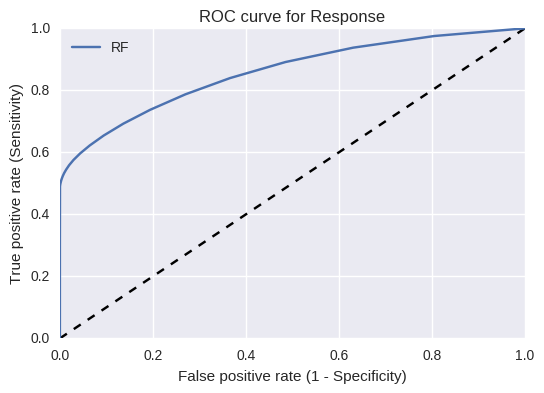


Test - RF - Area Under the Curve (AUC):  0.755666901886

Test - RF Histogram of predicted probabilities:


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    6.6s finished


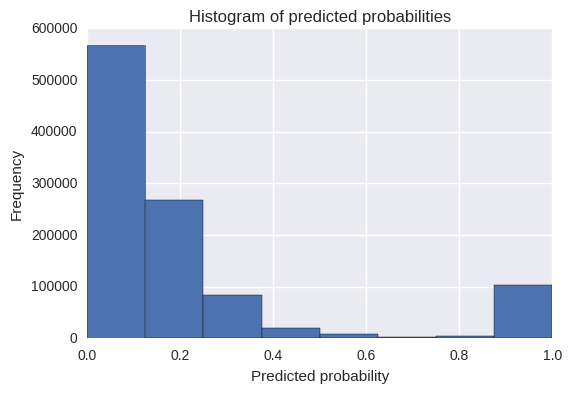


All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.45):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[829240   7455]
 [102612 116884]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.8s finished


Threshold probability: 0.45
Sensitivity: 0.532510843022
Specificity: 0.991089943169

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.5s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.45
Classification Accuracy =  0.895788735181
Classification Error =  0.104211264819
Sensitivity =  0.532510843022
Specificity =  0.991089943169
False Positive Rate =  0.00891005683074
Precision =  0.940042947104

All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.4):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[825588  11107]
 [100089 119407]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.5s finished


Threshold probability: 0.4
Sensitivity: 0.544000801837
Specificity: 0.986725150742

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.6s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.4
Classification Accuracy =  0.894719799733
Classification Error =  0.105280200267
Sensitivity =  0.544005357729
Specificity =  0.986725150742
False Positive Rate =  0.0132748492581
Precision =  0.914898018603

All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.35):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[812260  24435]
 [ 93187 126309]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.6s finished


Threshold probability: 0.35
Sensitivity: 0.575450122098
Specificity: 0.970795809704

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.7s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.35
Classification Accuracy =  0.888635672904
Classification Error =  0.111364327096
Sensitivity =  0.575450122098
Specificity =  0.970795809704
False Positive Rate =  0.0292041902963
Precision =  0.837903996179

All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.2):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[722614 114081]
 [ 67501 151995]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.7s finished


Threshold probability: 0.2
Sensitivity: 0.692472755768
Specificity: 0.863652824506

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.5s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.2
Classification Accuracy =  0.828078444145
Classification Error =  0.171921555855
Sensitivity =  0.692472755768
Specificity =  0.863652824506
False Positive Rate =  0.136347175494
Precision =  0.571246561133

All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.3):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[800343  36352]
 [ 88577 130919]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    6.0s finished


Threshold probability: 0.3
Sensitivity: 0.596452782739
Specificity: 0.95655286574

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.4s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.3
Classification Accuracy =  0.881717416641
Classification Error =  0.118282583359
Sensitivity =  0.596452782739
Specificity =  0.95655286574
False Positive Rate =  0.0434471342604
Precision =  0.782676016763

All for test dataset below
**************************

RF Confusion Matrix_Threshold (0.25):


/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


[[758101  78594]
 [ 75940 143556]]



[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.5s finished


Threshold probability: 0.25
Sensitivity: 0.654025585888
Specificity: 0.906068519592

Test - RF Confusion Matrix Metrics:
********************************


[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    5.7s finished
/home/tom/anaconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:386: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and willraise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  DeprecationWarning)


Threshold probability: 0.25
Classification Accuracy =  0.853687448577
Classification Error =  0.146312551423
Sensitivity =  0.654025585888
Specificity =  0.906066129235
False Positive Rate =  0.0939338707653
Precision =  0.646212018906

feature_class
nonPat        0.404659
age           0.106447
len           0.101924
dob           0.063448
income        0.055093
new           0.047836
no            0.044857
education     0.040157
division      0.031921
race          0.024819
poc           0.017492
marital       0.016735
payer         0.014582
occupation    0.013095
gender        0.009335
dwell         0.007600
dtype: float64
Total time taken for model_RF (sec) =  344.8767259120941


In [10]:
df = get_dataframe()
# set ccs_codes to empty list for all models
#print(df.head()) #debug
#print(df.info()) # debug
#add prepare df here once getting file locally

#for i in ccs_df.index:
#    ccs_master_rcrd = ccs_df.ix[i]
        
#    ccs_id = str( ccs_master_rcrd[0] )
#    recipe = str( ccs_master_rcrd[1] )
#    ccs_desc = str( ccs_master_rcrd[2] )
    
#    start = time.time()
#    df = ccs_df
#    end = time.time()    
#    print ('Total time taken for df (sec) = ', end - start)
# print('count',df.Target_Response.sum())    
features = list( df.columns[1:] )
labels = list( df.columns[0:1] )
        
X = df[list(features)].values
y = df[list(labels)].values
    
random_state = np.random.RandomState(0)
        
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)
    
start_RF = time.time()
#ccs_id='ccs_id_48'
#ccs_desc='Thyroid Disorder'
model_RF = build_model_RF( features, X_train, X_test, y_train, y_test )
        
rank_features( model_RF,  features )
end_RF = time.time()    
print ('Total time taken for model_RF (sec) = ', end_RF - start_RF)
    
    #start_DNN = time.time()
    #model_DNN = build_model_DNN( features,X_train, X_test, y_train, y_test, ccs_id, ccs_desc )
    #end_DNN = time.time()    
    #print ('Total time taken for model_DNN (sec) = ', end_DNN - start_DNN)
    
    #start_customDL = time.time()
    #model_customDL = build_model_customDL(features,X_train, X_test, y_train, y_test, ccs_id, ccs_desc )
    #end_customDL = time.time()    
    #print ('Total time taken for model_customDL (sec) = ', end_customDL - start_customDL)
    

In [11]:
df.head()

,Response,division_1,division_2,division_3,division_4,division_5,division_6,division_7,division_8,division_9,age_18,age_19,age_20,age_21,age_22,age_23,age_24,age_25,age_26,age_27,age_28,age_29,age_30,age_31,age_32,age_33,age_34,age_35,age_36,age_37,age_38,age_39,age_40,age_41,age_42,age_43,age_44,age_45,age_46,age_47,age_48,age_49,age_50,age_51,age_52,age_53,age_54,age_55,age_56,age_57,age_58,age_59,age_60,age_61,age_62,age_63,age_64,age_65,age_66,age_67,age_68,age_69,age_70,age_71,age_72,age_73,age_74,age_75,age_76,age_77,age_78,age_79,age_80,age_81,age_82,age_83,age_84,age_85,age_86,age_87,age_88,age_89,age_90,gender_F,gender_M,gender_U,dob_month_0,dob_month_1,dob_month_10,dob_month_11,dob_month_12,dob_month_2,dob_month_3,dob_month_4,dob_month_5,dob_month_6,dob_month_7,dob_month_8,dob_month_9,payer_type_M,payer_type_N,payer_type_P,payer_type_U,race_A,race_B,race_H,race_O,race_U,race_W,marital_status_M,marital_status_P,marital_status_S,marital_status_U,marital_status_W,marital_status_X,poc_N,poc_U,poc_Y,dwell_type_A,dwell_type_M,dwell_type_P,dwell_type_S,dwell_type_U,income_A,income_B,income_C,income_D,income_E,income_F,income_G,income_H,income_I,income_J,income_K,income_L,income_U,len_of_residence_0,len_of_residence_1,len_of_residence_10,len_of_residence_11,len_of_residence_12,len_of_residence_13,len_of_residence_14,len_of_residence_15,len_of_residence_16,len_of_residence_17,len_of_residence_18,len_of_residence_19,len_of_residence_2,len_of_residence_20,...,len_of_residence_46,len_of_residence_47,len_of_residence_48,len_of_residence_49,len_of_residence_5,len_of_residence_50,len_of_residence_51,len_of_residence_52,len_of_residence_53,len_of_residence_54,len_of_residence_55,len_of_residence_56,len_of_residence_57,len_of_residence_58,len_of_residence_59,len_of_residence_6,len_of_residence_60,len_of_residence_61,len_of_residence_62,len_of_residence_63,len_of_residence_64,len_of_residence_65,len_of_residence_66,len_of_residence_7,len_of_residence_8,len_of_residence_9,len_of_residence_99,no_of_persons_0,no_of_persons_1,no_of_persons_2,no_of_persons_3,no_of_persons_4,no_of_persons_5,no_of_persons_6,no_of_persons_7,no_of_persons_8,no_of_persons_999,education_0,education_1,education_2,education_3,education_4,education_5,occupation_0,occupation_1,new_mosaic_z4_global_A,new_mosaic_z4_global_B,new_mosaic_z4_global_C,new_mosaic_z4_global_D,new_mosaic_z4_global_E,new_mosaic_z4_global_F,new_mosaic_z4_global_G,new_mosaic_z4_global_H,new_mosaic_z4_global_I,new_mosaic_z4_global_J,new_mosaic_z4_global_U,nonPat_Mailings_1,nonPat_Mailings_10,nonPat_Mailings_11,nonPat_Mailings_12,nonPat_Mailings_13,nonPat_Mailings_14,nonPat_Mailings_15,nonPat_Mailings_16,nonPat_Mailings_17,nonPat_Mailings_18,nonPat_Mailings_19,nonPat_Mailings_2,nonPat_Mailings_20,nonPat_Mailings_21,nonPat_Mailings_22,nonPat_Mailings_23,nonPat_Mailings_24,nonPat_Mailings_25,nonPat_Mailings_26,nonPat_Mailings_27,nonPat_Mailings_28,nonPat_Mailings_29,nonPat_Mailings_3,nonPat_Mailings_30,nonPat_Mailings_31,nonPat_Mailings_32,nonPat_Mailings_33,nonPat_Mailings_34,nonPat_Mailings_35,nonPat_Mailings_36,nonPat_Mailings_37,nonPat_Mailings_38,nonPat_Mailings_39,nonPat_Mailings_4,nonPat_Mailings_40,nonPat_Mailings_41,nonPat_Mailings_42,nonPat_Mailings_43,nonPat_Mailings_44,nonPat_Mailings_45,nonPat_Mailings_46,nonPat_Mailings_47,nonPat_Mailings_48,nonPat_Mailings_49,nonPat_Mailings_5,nonPat_Mailings_50,nonPat_Mailings_51,nonPat_Mailings_52,nonPat_Mailings_53,nonPat_Mailings_54,nonPat_Mailings_55,nonPat_Mailings_56,nonPat_Mailings_57,nonPat_Mailings_58,nonPat_Mailings_59,nonPat_Mailings_6,nonPat_Mailings_60,nonPat_Mailings_61,nonPat_Mailings_62,nonPat_Mailings_63,nonPat_Mailings_64,nonPat_Mailings_65,nonPat_Mailings_66,nonPat_Mailings_67,nonPat_Mailings_68,nonPat_Mailings_69,nonPat_Mailings_7,nonPat_Mailings_70,nonPat_Mailings_71,nonPat_Mailings_72,nonPat_Mailings_73,nonPat_Mailings_74,nonPat_Mailings_75,nonPat_Mailings_76,nonPat_Mailings_77,nonPat_Mailings_78,nonPat_Mailings_79,nonPat_Mailin

# Lift(%) Calculation

Lift measures the performance of the model in predicting target (positive) classes at a certain percentile compared to the average prevalance in the population. A model will be performing good if it can identify the positive classes in a much better rate than the average for the population as a whole. It is simply the percent increase in prediction from average response at top (10th, 20th, and so on) percentile. It is obvious that at 100th percentile, model's prediction rate will be equal the the average response.

For example, suppose a population has an average response rate of 5%, but a certain model has identified a segment with a response rate of 20%. Then that segment would have a lift of 300% ((20-5)/5)*100%.

In [12]:
def performanceIndex_Lift ( model, y_test,X_test,percentile ):
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    y_pred_class = model.predict(X_test)
    y_test =  y_test.flatten()
    df_result = {'actual_class': y_test, 'pred_class': y_pred_class, 'pred_prob': y_pred_prob}
    df_result = pd.DataFrame(df_result, columns=['actual_class', 'pred_class', 'pred_prob'])
    df_result['record_no'] = df_result.index
    final_columns = ['record_no','actual_class', 'pred_class', 'pred_prob']
    df_result = df_result[final_columns]
    df_result = df_result.sort_values(by='pred_prob', ascending=0)
    df_result['rank'] = np.arange(len(df_result.index))
    df_result['percentile'] = df_result['rank'].apply(
        lambda x: (100*((x+1) - 0.5)/df_result['rank'].values[-1])) 
    
    print ('Actual Prevalance (%) =', round(df_result.actual_class.mean()*100,4) )
    print ('Prevalance at {}th Percentile (%) using Model ='.format(percentile),
           round(df_result[df_result['percentile'] <= int(percentile)].actual_class.mean()*100,4))
    print ('Lift in Predictabilty at {}th Percentile (%) ='.format(percentile),
           round((df_result[df_result['percentile'] <= int(percentile)].actual_class.mean() 
                  - df_result.actual_class.mean())*100/(df_result.actual_class.mean()),2))

In [13]:
performanceIndex_Lift ( model_RF, y_test,X_test,10 )

[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    6.0s finished
[Parallel(n_jobs=8)]: Done  30 out of  30 | elapsed:    6.0s finished


Actual Prevalance (%) = 20.7818
Prevalance at 10th Percentile (%) using Model = 99.9602
Lift in Predictabilty at 10th Percentile (%) = 381.0


## Run all above this cell to get initial output

In [ ]:
class Constant:
    FILE_PREFIX = "ccs"
    PATH = "../../../assets"

In [ ]:
class Helper:
    
    def generateFileName(self, prefix, name): 
        timestamp = time.strftime("%m:%d:%y:%H:%M:%S")
        fileName = "{}_{}_{}".format( prefix, name, timestamp )
        return fileName
    
    def saveFile(self,df):
        fileName = self.generateFileName( 
            Constant.FILE_PREFIX, 
            name = "predictions" 
        )
        
        filePath = "{}/{}.csv".format( 
            Constant.PATH, 
            fileName 
        )
        
        df.to_csv( path_or_buf = filePath, sep=',', index = False )

        print("Successfuly Saved Files to Path {}".format( Constant.PATH ))

In [ ]:
!ipython nbconvert --to=latex --template=latex_nocode.tplx MultiCssModelBuilding_Combined.ipynb